### Pulling from Mongo and Pandas


In [1]:
import pymongo
from redis import Redis

redis_connection = Redis(host='this_redis')
mongo_client = pymongo.MongoClient('this_mongo')


In [2]:
mongo_client.database_names()

['admin', 'config', 'local', 'twitter']

In [3]:
import pandas as pd

In [4]:
twentyktweets = pd.read_pickle('../data/twentyktweets.p')

In [5]:
# mongo_client.twitter.tweets.insert_many(twentyktweets.to_dict('records'))

In [6]:
# tweet_sample = twentyktweets.sample(20).to_dict('records')

In [7]:
# mongo_client.twitter.tweets_sample.insert_many(tweet_sample)

In [8]:
cur = (mongo_client
       .twitter
       .tweets_sample
       .find(projection={'_id': 0, 'text' : 1}))

In [9]:
next(cur)['text']

'😮'

### Parallel MapReduce

In [10]:
cd ..

/home/jovyan


In [11]:
from redis import Redis 
from rq import Queue
from lib.worker import remove_punctuation, mapper, reducer, toggle_hold, check_hold
import time
redis_connection = Redis('this_redis')
job_queue = Queue(connection=redis_connection)

Here is our previous implementation of the `word_count` function.

    def word_count(documents, redis_connection, word_list='word_list'):

        counts = []

        for document in documents:
            mapper(document, redis_connection, word_list)

        word = redis_connection.spop(word_list)
        while word:
            word = word.decode()
            count = reducer(word, redis_connection)
            counts.append((word, count))
            word = redis_connection.spop(word_list)

        return counts
        
There are two candidates for parallelization in this function:

1. the `for` loop can be parallelized as tokenization of one document is completely independent of the tokenization of another.
1. the `while` loop can be parallelized as the counting of tokens for one word is completely independent of the counting of another.

There was one tricky aspect to this parallelization, however. We cannot work on the word counts until all of the tokenization is complete.

In [12]:
def map_documents_mongo(cursor):
    for document in cursor:
        job = job_queue.enqueue(mapper, document['text'], 'word_list')
    return job

In [13]:
def reduce_words():

    word = redis_connection.spop('word_list')
    while word:
        word = word.decode()
        job = job_queue.enqueue(reducer, word, 'count_list')
        word = redis_connection.spop('word_list')
    
    return job

In [14]:
def collect_counts():
    
    counts = []
    count = redis_connection.lpop('count_list')
    while count:
        counts.append(count)
        count = redis_connection.lpop('count_list')
        
        
    counts = [remove_punctuation(count.decode())
              for count in counts]
    counts = [count.split()
              for count in counts]
    counts = [(count[0], int(count[1]))
              for count in counts]
    return counts

In [24]:
cur = (mongo_client
       .twitter
       .tweets_sample
       .find(projection={'_id': 0, 'text' : 1}))
job = map_documents_mongo(cur)

print("Mapping Documents.")
status = job.status
while status != 'finished':
    print(".", end="")
    status = job.status
    time.sleep(0.1)

job = reduce_words()

print("\nReducing Word Tokens.")
status = job.status
while status != 'finished':
    print(".", end="")
    status = job.status
    time.sleep(0.1)

results = pd.DataFrame(collect_counts(), columns=['word', 'count'])

results.sort_values('count', ascending=False).head(10)

Mapping Documents.
.................
Reducing Word Tokens.
.............................................................................................................

,word,count
114,the,5
149,of,5
109,happy,3
77,a,3
56,•,2
57,are,2
126,birthday,2
123,and,2
68,to,2
78,bitch,2


In [25]:
def map_documents_pandas(series):
    for document in series.values:
        job = job_queue.enqueue(mapper, document, 'word_list')
    return job

In [27]:
def word_count_pandas_sample(n, track=True):
    start = time.time()
    job = map_documents_pandas(twentyktweets.sample(n)['text'])
    if track: print("Mapping Documents.")
    status = job.status
    while status != 'finished':
        if track: print(".", end="")
        status = job.status
        time.sleep(0.1)

    job = reduce_words()
    if track: print("\nReducing Word Tokens.")
    status = job.status
    while status != 'finished':
        if track: print(".", end="")
        status = job.status
        time.sleep(0.1)

    results = pd.DataFrame(collect_counts(), columns=['word', 'count'])
    
    return time.time() - start, results

In [28]:
sample_sizes = [5,10,20,50,100,200]
timing = []
for n in sample_sizes:
    print('counting {} samples'.format(n))
    count_time, results = word_count_pandas_sample(n, track=False)
    timing.append({'n': n, 'count_time' : count_time , 'workers' : 1})

counting 5 samples
counting 10 samples
counting 20 samples
counting 50 samples
counting 100 samples
counting 200 samples


In [29]:
t = pd.DataFrame(timing)

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

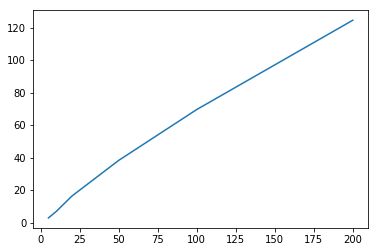

In [31]:
plt.plot(t.n, t.count_time)

In [32]:
sample_sizes = [5,10,20,50,100,200]
for n in sample_sizes:
    print('counting {} samples'.format(n))
    count_time, results = word_count_pandas_sample(n, track=False)
    timing.append({'n': n, 'count_time' : count_time , 'workers' : 2})

counting 5 samples
counting 10 samples
counting 20 samples
counting 50 samples
counting 100 samples
counting 200 samples


In [36]:
t = pd.DataFrame(timing)

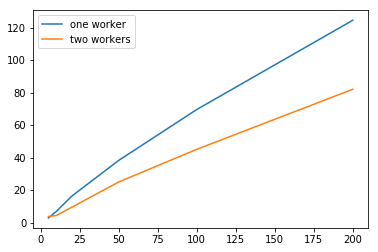

In [37]:
plt.plot(t[t.workers == 1].n, t[t.workers == 1].count_time, label='one worker')
plt.plot(t[t.workers == 2].n, t[t.workers == 2].count_time, label='two workers')
plt.legend()